# Scott Breitbach
## Milestone 5: Merging the Data and Storing in a Database/Visualizing Data
## 26-Feb-2021
## DSC540, Weeks 11-12

In [1]:
import sqlite3
import pandas as pd
import numpy as np

# Load data into an SQL database, each as an individual table.

In [2]:
# Load the previously cleaned data from CSV files:
csvData = pd.read_csv("CSV_nebraskaCleaned.csv")
webData = pd.read_csv("WEB_NEbeerReddit.csv")
apiData = pd.read_csv("API_beerMapping.csv")

## First, a little extra cleaning

#### Replace spaces in column names with underscores:

In [3]:
def colSpaceToUnderscore(df):
    '''Replaces spaces with underscores in the column names of a DataFrame'''
    newCols = []
    for c in df.columns:
        newCols.append(c.replace(' ', '_'))
    df.columns = newCols
    print(f"New column names:\n{df.columns}")  

In [4]:
colSpaceToUnderscore(csvData)
colSpaceToUnderscore(webData)
colSpaceToUnderscore(apiData)

New column names:
Index(['Brewery_ID', 'Brewery_Name', 'Type_of_Brewery', 'Street_Address',
       'City', 'State', 'Postal_Code', '5-digit_Zip', 'Website', 'Phone',
       'Longitude', 'Latitude'],
      dtype='object')
New column names:
Index(['Brewery_Name', 'City', 'State', 'Type_of_Brewery',
       'Type_of_Distribution', 'Notes', '#_Locations', 'Locations'],
      dtype='object')
New column names:
Index(['BreweryID', 'BreweryName', 'Type', 'ReviewLink', 'ProxyLink', 'Map',
       'StreetAddress', 'City', 'State', 'Zip', 'Country', 'PhoneNum',
       'Website', 'Rating', 'ImageCount'],
      dtype='object')


#### Make street addresses a uniform format:

In [5]:
import pandas_usaddress

def standardizeAddress(df, colName):
    '''Creates street address uniformity and makes Title Case;
    Replaces existing street address column.'''
    tempDF = pd.DataFrame()
    addressDF = pd.DataFrame()
    
    tempDF = pandas_usaddress.tag(df, [colName], granularity='single', standardize=True) 
    addressDF['Address'] = tempDF.SingleLine.str.title()
    tempDF = pandas_usaddress.tag(df, [colName], granularity='medium', standardize=True) 
    addressDF['Suffix'] = tempDF.OccupancySuite.str.title()
    
    for i in range(len(addressDF.Address)):
        addressDF['Address'][i] = addressDF.Address[i].rstrip(str(addressDF.Suffix[i])).strip()
        
    df[colName] = addressDF['Address']

In [6]:
standardizeAddress(csvData, 'Street_Address')
standardizeAddress(apiData, 'StreetAddress')

In [7]:
# A few manual fixes:
csvData['Street_Address'] = csvData['Street_Address'].str.replace(' Blackstone District', '')
csvData['Street_Address'] = csvData['Street_Address'].str.replace('500 W South', '500 W South St')
apiData['StreetAddress'] = apiData['StreetAddress'].str.replace('710Th Rd', '62193 710Th Rd')
csvData.State = 'NE'
webData.State = 'NE'

#### Add a column for consolidating Omaha suburbs:
https://en.wikipedia.org/wiki/Neighborhoods_of_Omaha,_Nebraska

In [8]:
import requests
# Use table from Wikipedia page to generage a list of suburbs:
url = "https://en.wikipedia.org/wiki/Neighborhoods_of_Omaha,_Nebraska"
listOfTables = pd.read_html(url)
omahaSubsDF = listOfTables[1]
omahaSubs = list(omahaSubsDF['Neighborhoods in Omaha alphabetical order'][1:])

In [9]:
def fixCitySpacing(df):
    df['City'].replace('Mc Cook', 'McCook', inplace=True)
    df['City'].replace('LaVista', 'La Vista', inplace=True)

In [10]:
fixCitySpacing(csvData)
fixCitySpacing(webData)
fixCitySpacing(apiData)

In [11]:
def omahaSuburbs(df, colName):
    '''Creates a copy of the City column and converts any locations 
    found in the list of Omaha suburbs to "Omaha"'''
    df['Central_City'] = df[colName]
    df.loc[(df['Central_City'].isin(omahaSubs) == True), 'Central_City'] = "Omaha"

In [12]:
omahaSuburbs(csvData, 'City')
omahaSuburbs(webData, 'City')
omahaSuburbs(apiData, 'City')

#### Standardize phone numbers:

In [13]:
import phonenumbers as pn
import numpy as np

def fixPhoneNums(df, colName):
    '''Attempts to convert each phone number to a standardized format and add
    to a list, adding NaN if it fails. Assigns the list back to the DF column.'''
    phList = []
    for i in range(len(df[colName])):
        try:
            phList.append(pn.format_number(pn.parse(df[colName][i], 'US'), 
                                           pn.PhoneNumberFormat.NATIONAL))
        except:
            phList.append(np.nan)
    df[colName] = phList

In [14]:
fixPhoneNums(apiData, 'PhoneNum')

#### Standardize Brewery Names:

In [15]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def fuzzyMatch(df, colName, scorer=fuzz.ratio, display=False):
    '''Fuzzy matches a column of brewery names against a standard set of names.
    `display=True`  returns a DF comparing old with new names plus a score.
    `display=False` returns a Series of the corrected names.'''
    checkDF = df.copy()
    actualDF = webData.copy()
    testDF = pd.DataFrame()
    testDF['NamesToCheck'] = checkDF[colName]
    
    actualName = []
    similarity = []
    for i in testDF['NamesToCheck']:
        ratio = process.extract(i, actualDF['Brewery_Name'], 
                                limit=1, scorer=scorer) 
        actualName.append(ratio[0][0])
        similarity.append(ratio[0][1])
        testDF['NameMatch'] = pd.Series(actualName)
        testDF['Score'] = pd.Series(similarity)
    
    if display == True:
        print('Average Score: {0:.2f}'.format(testDF['Score'].mean()))
        return testDF.sort_values('Score', ascending=False)
    elif display == False:
        return testDF['NameMatch']

In [16]:
csvData['Brewery_Name'] = fuzzyMatch(csvData, 'Brewery_Name', 
                                     fuzz.partial_ratio, display=False)

In [17]:
apiData['BreweryName'] = fuzzyMatch(apiData, 'BreweryName', 
                                    fuzz.token_sort_ratio, display=False)

#### Remove Granite City (not a Nebraska brewery):

In [18]:
def removeGC(df, colName):
    return df[df[colName] != 'Granite City Food & Brewery']

In [19]:
csvData = removeGC(csvData, 'Brewery_Name')
webData = removeGC(webData, 'Brewery_Name')
apiData = removeGC(apiData, 'BreweryName')

#### Fix an incorrect zip code:

In [20]:
apiData.loc[apiData['BreweryName'] == 'Code Beer Company', ['Zip']] = 68510

## Load DataFrames into an SQL Database

In [21]:
# Load data into an SQL database, each as an individual table:
with sqlite3.connect('Nebeerska.db') as conn:
    cursor = conn.cursor()
    csvData.to_sql('csvtable', conn, if_exists='replace', index=False)
    webData.to_sql('webtable', conn, if_exists='replace', index=False)
    apiData.to_sql('apitable', conn, if_exists='replace', index=False)

### Get a list of the tables:

In [22]:
res = conn.execute('''SELECT name FROM sqlite_master WHERE type='table';''')
tableList = []
for name in res:
    print(name[0])
    tableList.append(name[0])

csvtable
webtable
apitable


### Check out the first few rows of each table:

In [23]:
def head(table, nRows=5):
    '''Prints the first n rows of the table specified'''
    cursor.execute(f'''SELECT * FROM {table}''')
    for row in cursor.fetchall()[:nRows]:
        print(row)

In [24]:
for i in tableList:
    print(f"Table: '{i}' - ")
    head(i, 3)
    print()

Table: 'csvtable' - 
('backswing-brewing-co-lincoln', 'Backswing Brewing Co.', 'Micro', '500 W South St', 'Lincoln', 'NE', '68522-1744', 68522, 'http://www.backswingbrewing.com', '(402) 515-4263', None, None, 'Lincoln')
('benson-brewery-omaha', 'Benson Brewery', 'Brewpub', '6059 Maple St', 'Omaha', 'NE', '68104-4050', 68104, 'http://www.bensonbrewery.com', '(402) 934-8668', -96.00634511, 41.28489756, 'Omaha')
('boiler-brewing-company-lincoln', 'Boiler Brewing Company', 'Micro', '129 N 10Th', 'Lincoln', 'NE', '68508-3633', 68508, 'http://www.boilerbrewingcompany.com', '(402) 261-8775', None, None, 'Lincoln')

Table: 'webtable' - 
('Backswing Brewing Co.', 'Lincoln', 'NE', 'Micro', 'On-tap at the brewery and at select locations', 'Distro planned for 2016', 1, 'Lincoln', 'Lincoln')
('Benson Brewery', 'Omaha', 'NE', 'Taproom', 'On tap only at the brewery', 'Other beers, locals included, on tap. Omaha Brewing is the parent company', 1, 'Omaha', 'Omaha')
('Boiler Brewing Company', 'Lincoln',

In [25]:
# pd.read_sql_query('select * from csvTable limit 3', conn)

In [26]:
# pd.read_sql_query('select * from webTable limit 3', conn)

In [27]:
# pd.read_sql_query('select * from apiTable limit 3', conn)

# Join the datasets together into 1 dataset.

#### Use `UNION` to merge two similar datasets:

In [28]:
with sqlite3.connect('Nebeerska.db') as conn:
    cursor = conn.cursor()
    cursor.execute("PRAGMA foreign_keys = 1") 
    sql = """
        CREATE TABLE brewAddresses AS
            SELECT BreweryName, StreetAddress, City, State, Zip
                FROM apitable
            UNION
            SELECT Brewery_Name, Street_Address, City, State, `5-digit_Zip`
                FROM csvtable;
    """
    cursor.execute(sql)

In [29]:
pd.read_sql_query('SELECT * FROM brewAddresses LIMIT 3', conn)

,BreweryName,StreetAddress,City,State,Zip
0,Backswing Brewing Co.,500 W South St,Lincoln,NE,68522
1,Benson Brewery,6059 Maple St,Omaha,NE,68104
2,Boiler Brewing Company,129 N 10Th,Lincoln,NE,68508


#### Use 'JOIN' to add data to that merged table

In [30]:
combinedData = pd.read_sql_query("SELECT "
    "webTable.Brewery_Name, brewAddresses.StreetAddress, webTable.City, "
                                 "webTable.State, brewAddresses.Zip, csvTable.Longitude, csvTable.Latitude "
    "FROM webTable "
    "LEFT JOIN "
    "brewAddresses ON webTable.Brewery_Name = brewAddresses.BreweryName AND webTable.City = brewAddresses.City "
    "LEFT JOIN "
    "csvTable ON webTable.Brewery_Name = csvTable.Brewery_Name AND webTable.City = csvTable.City;", conn)

In [31]:
omahaSuburbs(combinedData, 'City')

In [32]:
combinedData.head()

,Brewery_Name,StreetAddress,City,State,Zip,Longitude,Latitude,Central_City
0,Backswing Brewing Co.,500 W South St,Lincoln,NE,68522.0,NaN,NaN,Lincoln
1,Benson Brewery,6059 Maple St,Omaha,NE,68104.0,-96.006345,41.284898,Omaha
2,Boiler Brewing Company,129 N 10Th,Lincoln,NE,68508.0,NaN,NaN,Lincoln
3,Bolo Beer Co.,420 E 1St St,Valentine,NE,69201.0,-100.545728,42.872047,Valentine
4,"Bootleg Brewers, Sandhills Brewing Co.",45145 829Th Rd,Taylor,NE,68879.0,NaN,NaN,Taylor


#### Create a table of all brewery types

In [33]:
with sqlite3.connect('Nebeerska.db') as conn:
    cursor = conn.cursor()
    cursor.execute("PRAGMA foreign_keys = 1") 
    sql = """
        CREATE TABLE brewTypes AS
            SELECT Brewery_Name, Type_of_Brewery
                FROM webTable
            UNION
            SELECT BreweryName, Type
                FROM apiTable
            UNION
            SELECT Brewery_Name, Type_of_Brewery
                FROM csvTable;
    """
    cursor.execute(sql)

In [34]:
typesDF = pd.read_sql_query("SELECT * FROM brewTypes", conn)

# Create 5 visualizations that demonstrate the data.
Note: At least 2 should have data from > 1 source.

In [35]:
import matplotlib.pyplot as plt

### Map of Breweries in Nebraska

In [36]:
BBox = (-104.194, -95.219, 43.117, 39.884)

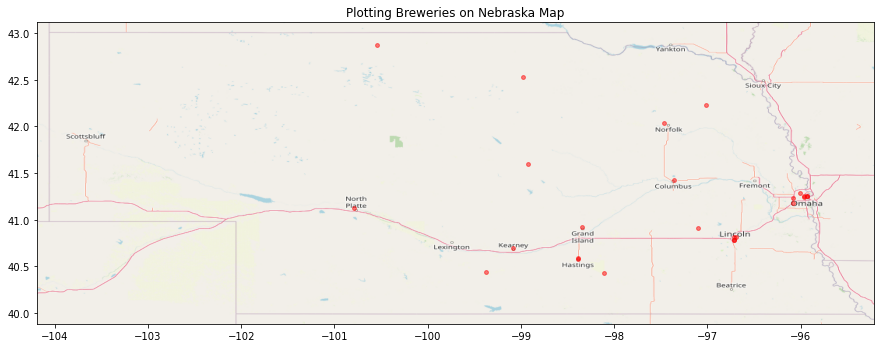

In [37]:
mymap = plt.imread("NEmapInv.png")

plt.subplots(figsize = (15, 8))
plt.scatter(combinedData.Longitude, combinedData.Latitude, zorder=1, alpha=0.5, c='r', s=15)
plt.title('Plotting Breweries on Nebraska Map')
plt.xlim(BBox[0], BBox[1])
plt.ylim(BBox[3], BBox[2])

plt.imshow(mymap, zorder=0, extent = BBox, aspect='equal')

### Number of Breweries by City

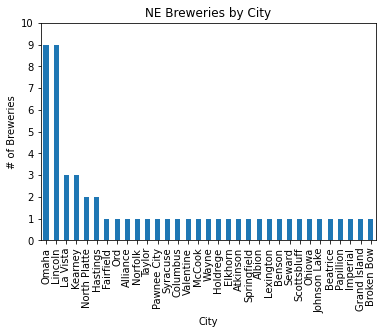

In [38]:
combinedData['City'].value_counts().plot(kind='bar')

plt.title('NE Breweries by City')
plt.xlabel('City')
plt.ylabel('# of Breweries')
plt.yticks(range(0,11))
plt.show()

Some of these cities are suburbs of Omaha. Let's fix that and see how Omaha really compares:

In [39]:
omahaSuburbs(combinedData, 'City')

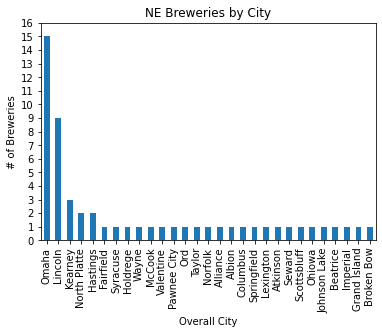

In [40]:
combinedData['Central_City'].value_counts().plot(kind='bar')

plt.title('NE Breweries by City')
plt.xlabel('Overall City')
plt.ylabel('# of Breweries')
plt.yticks(range(0,17))
plt.show()

### Compare Brewery Ratings
Note: There were only a limited number of breweries with ratings available.

In [41]:
ratingsDF = apiData[apiData['Rating'] != 0]
ratingsDF = ratingsDF.sort_values('Rating', ascending=False)

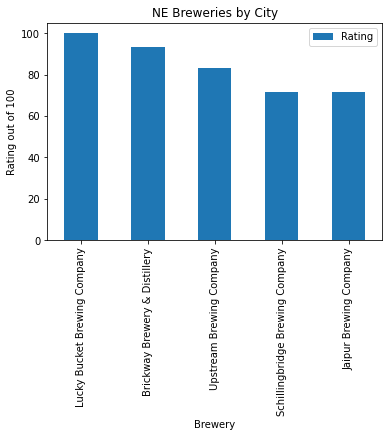

In [42]:
ratingsDF.plot('BreweryName', 'Rating', kind='bar')

plt.title('NE Breweries by City')
plt.xlabel('Brewery')
plt.ylabel('Rating out of 100')
plt.show()

### Compare Types of Breweries

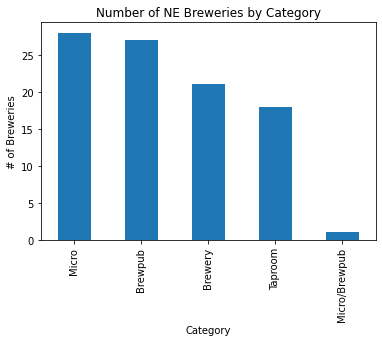

In [43]:
typesDF['Type_of_Brewery'].value_counts().plot(kind='bar')

plt.title('Number of NE Breweries by Category')
plt.xlabel('Category')
plt.ylabel('# of Breweries')
plt.show()

The project for DSC540 has overall been one of my favorites so far because I feel like I've learned a lot and each Milestone was designed to reinforce concepts learned from each unit. I definitely had some struggles and probably spent way more time than I should have trying to figure out how to do certain things. Web scraping with Beautiful Soup was new to me and, while I found it really challenging at first, I started to get the hang of it after some practice. Right now I'm really struggling with SQL in much the same way, but again, the more I use it the more it makes sense.  
One of the biggest issues I ran into was simply finding data I could use with an API. There are lots of good sources out there, but some aren't available to student research, or APIs are being updated and aren't available at the moment, or they are old and no longer supported. When my first choice for beer data (Untappd) wasn't available to use for my purposes, I tried finding other sources and requested API keys. Eventually I ended up using what was probably my fourth choice, which limited the overall amount of data I had to work with, but I think it worked out okay in the end.  
Another thing I found was that I needed to do more cleaning with my data in order to make it work cleanly with the SQL database. This was kind of nice though, because it kept some of the other things I've learned fresh, while also learning some of the ins & outs of working with databases.  